# Import Dependencies


In [45]:
# Importing necessary libraries
import os
import glob
import time
import requests
import zipfile
from datetime import timedelta, date

import pandas as pd
import numpy as np
from geopy.distance import geodesic
import folium
import seaborn as sns
import matplotlib.pyplot as plt


# The stride client library, used to make the calls to the stride api
import stride

In [ ]:
DATA_FOLDER = './2023_siri_data'

# Data Collection

Our data is sourced from the Open-Bus Stride ETL packages. These packages provide data in hourly intervals. The data includes information about bus locations, the nearest stop to each bus location, and correlations to the GTFS ride. This includes the date and time of scheduled arrival times, among other details.


## Data Download Function

In this cell, we define a function `download_files` to download and extract the data files for a given year.

The function iterates over each day and hour in the year, constructs the corresponding file URL, and sends a GET request to download the file. If the file is successfully downloaded, it is saved in the 'compressed' directory and then extracted to the 'data' directory.

If the file is not found on the server, its URL is added to a list of missing files, which is printed at the end of the function.

The function also reads and writes the last downloaded date and hour from/to a file, allowing the download process to be resumed if it is interrupted.

Finally, we call the function to download the files for the year 2023.


In [364]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def download_files(year):
    start_date = date(year, 1, 1)
    end_date = date(year+1, 1, 1)
    missing_files = []

    if not os.path.exists(f'{DATA_FOLDER}/compressed'):
        os.makedirs(f'{DATA_FOLDER}/compressed')
    if not os.path.exists(f'{DATA_FOLDER}/data'):
        os.makedirs(f'{DATA_FOLDER}/data')

    # Read the start date and hour from a file
    try:
        with open(f'{DATA_FOLDER}/last_downloaded.txt', 'r') as f:
            last_downloaded = f.read().strip()
            start_date = date(int(last_downloaded[:4]), int(last_downloaded[5:7]), int(last_downloaded[8:10]))
            start_hour = int(last_downloaded[11:13])
    except FileNotFoundError:
        start_hour = 0

    for single_date in daterange(start_date, end_date):
        for hour in range(start_hour, 24):
            filename = f"{single_date.strftime('%Y-%m-%d')}.{str(hour).zfill(2)}"
            url = f"https://s3.eu-west-2.wasabisys.com/stride/stride-etl-packages/siri/{single_date.strftime('%Y/%m')}/{filename}.zip"
            response = requests.get(url)
            if response.status_code == 200:
                with open(f"{DATA_FOLDER}/compressed/{filename}.zip", 'wb') as f:
                    f.write(response.content)
                with zipfile.ZipFile(f"{DATA_FOLDER}/compressed/{filename}.zip", 'r') as zip_ref:
                    if f"{filename}.csv" in zip_ref.namelist():
                        zip_ref.extract(f"{filename}.csv", path=f'{DATA_FOLDER}/data')
                # Save the current date and hour to a file
                with open(f'{DATA_FOLDER}/last_downloaded.txt', 'w') as f:
                    f.write(f"{single_date.strftime('%Y-%m-%d')}.{str(hour).zfill(2)}")
            else:
                missing_files.append(url)
        start_hour = 0

    print("Missing files:")
    for file in missing_files:
        print(file)

In [ ]:
# download_files(2023)

## Keeping the data intact

We might have a missing file in the data folder
This function checks for missing files based on the compressed files folder


In [365]:
def extract_missing_csv(zip_dir, csv_dir):
    # Get a list of all ZIP files
    zip_files = glob.glob(f'{zip_dir}/*.zip')

    for zip_file in zip_files:
        # Get the corresponding CSV file name
        csv_file_name = os.path.basename(zip_file)[:-4] + '.csv'
        csv_file_path = f'{csv_dir}/{csv_file_name}'
        
        # If the CSV file does not exist
        if not os.path.exists(csv_file_path):
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                # Extract the CSV file
                if csv_file_name in zip_ref.namelist():
                    zip_ref.extract(csv_file_name, path=csv_dir)

In [ ]:
# extract_missing_csv(f'{DATA_FOLDER}/compressed', f'{DATA_FOLDER}/data')

## Data Segmentation

To optimize memory usage and improve data accessibility, we will segment our data into chunks. Each new file will contain 1 million rows from the original dataset.

Additionally, we will remove currently unnecessary columns to streamline our data. If required in the future, we can retrieve the omitted data using the Stride client.


In [6]:
import re
import os
import glob
import pandas as pd
def get_folder_size(folder_path):
    total = 0
    for path, dirs, files in os.walk(folder_path):
        for f in files:
            fp = os.path.join(path, f)
            total += os.path.getsize(fp)
    return total

def process_files(folder_path):
    print(f"Folder size before processing: {get_folder_size(folder_path)} bytes")

    df = pd.DataFrame()

    csv_files = glob.glob(f'{folder_path}/data/*.csv')

    csv_files.sort()

    file_counter = 1

    output_files = glob.glob(f'{folder_path}/concatenated_data/output_*.csv')
    if output_files:
        output_files.sort()
        last_file = output_files[-1]
        file_counter = int(re.findall(r'\d+', last_file)[0])

        # If the last output file contains less than 1 million lines, load it into df
        if sum(1 for line in open(last_file)) < 1000000:
            df = pd.read_csv(last_file)
            os.remove(last_file)  # remove the last file as it will be rewritten later
        else:
            file_counter += 1

    for file in csv_files:
        # If the file is not empty
        if os.path.getsize(file) > 0:
            try:
                temp_df = pd.read_csv(file)

                # Drop the unnecessary columns
                temp_df = temp_df.drop(columns=['gtfs_agency_name', 'gtfs_stop_name', 'gtfs_route_long_name', 'gtfs_line_ref', 'gtfs_operator_ref', 'distance_from_siri_ride_stop_meters', 'distance_from_journey_start'])
                df = pd.concat([df, temp_df])
                
                # If the main DataFrame has reached 1 million rows
                while df.shape[0] >= 1000000:
                    df[:1000000].to_csv(f'{folder_path}/concatenated_data/output_{file_counter}.csv', index=False)
                    # Keep the remaining rows in the DataFrame
                    df = df[1000000:]
                    file_counter += 1
            except pd.errors.EmptyDataError:
                print(f"File {file} is empty or only contains a header. Deleting and moving on.")
        
        # Delete the old CSV file
        os.remove(file)

    # Write the remaining rows in the DataFrame to a CSV file
    if not df.empty:
        df.to_csv(f'{folder_path}/concatenated_data/output_{file_counter}.csv', index=False)

    print(f"Folder size after processing: {get_folder_size(folder_path)} bytes")

Folder size before processing: 60528706263 bytes


In [ ]:
process_files(DATA_FOLDER)

# Data Examination

In this phase, we will focus on analyzing a single bus line, specifically line 68, which operates from Kiryat Ono terminal to Tel-Aviv central station. Our analysis will be limited to the first month of 2023.

Our primary goal is to identify instances of delays and subsequently investigate potential causes for these delays.

To facilitate this, we will prepare a DataFrame that consolidates all relevant data pertaining to this bus line.


In [ ]:
def create_filtered_df(csv_dir, line_refs, limit=0, offset=0):
    # Get a list of all output CSV files
    csv_files = glob.glob(f'{csv_dir}/output_*.csv')
    
    # Apply the limit and offset
    if limit > 0:
        csv_files = csv_files[offset:offset+limit]
    else:
        csv_files = csv_files[offset:]

    # Initialize an empty DataFrame
    df = pd.DataFrame()

    # Initialize a counter for the update message
    counter = 0

    for file in csv_files:
        # Read the CSV file
        temp_df = pd.read_csv(file)
        
        # Filter the rows where 'siri_line_ref' is in the list of line_refs
        temp_df = temp_df[temp_df['siri_line_ref'].isin(line_refs)]
        
        # Concatenate the filtered rows to the main DataFrame
        df = pd.concat([df, temp_df])

        # Increment the counter
        counter += 1

        # If the counter reaches 20, print an update message and reset the counter
        if counter % 20 == 0:
            print(f'Processed {counter} files. Current file: {file}')

    return df

In [ ]:
df = create_filtered_df(f'{DATA_FOLDER}/concatenated_data', [989], 30)

df.head()

## Sorting and Formatting Data

In this step, we sort the dataframe `df` by 'siri_journey_ref' and 'recorded_at_time'. We also convert the 'gtfs_arrival_time' and 'recorded_at_time' columns to datetime format for easier manipulation in later steps.

We then create two new dataframes:

- `df_bus_journey_stops`: This dataframe is created by selecting specific columns from `df_sorted` and dropping duplicates. It contains information about the bus journey stops.

- `df_locations`: This dataframe is created by excluding columns that start with 'gtfs' from `df_sorted`. It contains information about the bus locations.


In [35]:
def process_dataframe(df):
    df_sorted = df.sort_values(['siri_journey_ref', 'recorded_at_time'])
    
    # Convert all columns ending with '_time' to datetime
    for col in df_sorted.columns:
        if col.endswith('_time'):
            df_sorted[col] = pd.to_datetime(df_sorted[col])
    
    df_bus_journey_stops = df_sorted[['siri_journey_ref', 'siri_vehicle_ref', 'siri_stop_code', 'siri_stop_order', 'siri_operator_ref', 'siri_line_ref', 'gtfs_journey_ref', 'gtfs_start_time', 'gtfs_end_time', 'gtfs_stop_code', 'gtfs_stop_lat', 'gtfs_stop_lon', 'gtfs_stop_city', 'gtfs_arrival_time', 'gtfs_stop_sequence', 'gtfs_line_ref', 'gtfs_route_short_name', 'gtfs_route_direction', 'gtfs_route_mkt']].copy().drop_duplicates()

    # Remove rows where 'gtfs_stop_lat' or 'gtfs_stop_lon' is NaN
    df_bus_journey_stops = df_bus_journey_stops.dropna(subset=['gtfs_stop_lat', 'gtfs_stop_lon'])

    df_locations = df_sorted[[col for col in df_sorted.columns if not col.startswith('gtfs')]].copy()
    return df_bus_journey_stops, df_locations

In [ ]:
df_bus_journey_stops, df_locations = process_dataframe(df)

## Calculating Distance and Speed

In this step, we define a function `calculate_distance_and_speed` to calculate the distance and speed for each journey.

- The function first calculates the distances between consecutive locations using the `geodesic` function from the `geopy.distance` module.
- It then calculates the time difference between consecutive locations and uses this to calculate the speed.
- Any `NaN` values in the 'speed', 'distance', and 'time_diff' columns are replaced with 0.

Finally, we apply this function to our DataFrame `df_locations` using the `groupby` and `apply` methods, and reset the index.


In [36]:
def calculate_distance_and_speed(group):
    lats = group['lat'].to_numpy()
    lons = group['lon'].to_numpy()

    distances = np.array([geodesic((lats[i], lons[i]), (lats[i+1], lons[i+1])).km for i in range(len(lats)-1)])

    group['distance'] = np.append(distances, np.nan)

    group['time_diff'] = (group['recorded_at_time'].shift(-1) - group['recorded_at_time']).dt.total_seconds() / 3600

    # Calculate speed, handle division by zero gracefully
    group['speed'] = group['distance'] / (group['time_diff'] + 1e-9)

    # Replace NaN values in 'speed' with 0
    group['speed'] = group['speed'].fillna(0)
    group['distance'] = group['distance'].fillna(0)
    group['time_diff'] = group['time_diff'].fillna(0)

    return group

def process_locations(df_locations):
    df_locations = df_locations.groupby('siri_journey_ref').apply(calculate_distance_and_speed)
    df_locations = df_locations.reset_index(drop=True)
    return df_locations

In [ ]:
df_locations = process_locations(df_locations)

## Calculating Arrival Times

In this step, we define several functions to calculate the estimated arrival times at each bus stop for each journey.

- The `haversine` function calculates the distance between two points on the Earth's surface given their latitudes and longitudes.
- The `calculate_bearing` function calculates the bearing between two points on the Earth's surface.
- The `calculate_arrival_times` function uses the above two functions to estimate the arrival times at each bus stop for each journey. It takes into account the speed of the bus, the distance to the next stop, and the direction of the bus.

An important part of the `calculate_arrival_times` function is the calculation of the 'moving_towards_stop' field. This field is a boolean that indicates whether the bus is moving towards or away from the stop. It is calculated by comparing the bearing of the bus to the bearing of the line from the bus to the stop. If the bus's bearing is within a certain range of the bearing to the stop, then the bus is considered to be moving towards the stop. This calculation is important because it allows us to distinguish between a bus that is approaching a stop and a bus that has already passed a stop.

The 'distance_from_stop' field is the distance from the closest bus location to the stop. It is calculated using the `haversine` function.

The 'estimated_arrival_time' field is the estimated time that the bus will arrive at the stop. It is calculated by adding the estimated time to the stop (which is the distance to the stop divided by the speed of the bus) to the time that the closest location was recorded. If the bus is moving away from the stop, the estimated time to the stop is subtracted from the recorded time instead.

Finally, we call the `calculate_arrival_times` function to calculate the estimated arrival times for our data.


In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert coordinates to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def calculate_bearing(lat1, lon1, lat2, lon2, bearing_threshold=15):
    # Convert coordinates to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Calculate the difference in longitudes
    dlon = lon2 - lon1

    # Calculate the bearing
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    bearing = np.degrees(np.arctan2(x, y))

    # Normalize the bearing to be between 0 and 360
    bearing = (bearing + 360) % 360

    # Calculate the range of acceptable bearings
    lower_bearing = (bearing - bearing_threshold + 360) % 360
    upper_bearing = (bearing + bearing_threshold) % 360

    return lower_bearing, upper_bearing

def calculate_arrival_times(df_locations, df_bus_journey_stops, bearing_threshold=15):
    results = []

    for journey, journey_locations in df_locations.groupby('siri_journey_ref'):
        journey_locations = journey_locations.sort_values('recorded_at_time')

        # Replace zero speed values with NaN
        journey_locations['speed'].replace(0, np.nan, inplace=True)

        # Interpolate to fill NaN values with the nearest non-NaN values
        journey_locations['speed'].interpolate(method='nearest', limit_direction='both', inplace=True)

        # Calculate the mean speed excluding the start and end points
        mean_speed = journey_locations['speed'][1:-1].mean()

        # Fill remaining NaN values at the start and end of the series with the mean speed
        journey_locations['speed'].fillna(mean_speed, inplace=True)

        # Extract the journey's bus stops
        journey_stops = df_bus_journey_stops[df_bus_journey_stops['siri_journey_ref'] == journey]

        # Skip the journey if it only has 2 or fewer stops
        if len(journey_stops) <= 2:
            continue

        # Iterate over each bus stop in the journey
        for _, stop in journey_stops.iterrows():
            distances = haversine(journey_locations['lat'], journey_locations['lon'], stop['gtfs_stop_lat'], stop['gtfs_stop_lon'])
            bearings = calculate_bearing(journey_locations['lat'], journey_locations['lon'], stop['gtfs_stop_lat'], stop['gtfs_stop_lon'], bearing_threshold)

            moving_towards_stop = ((journey_locations['bearing'] >= bearings[0]) & (journey_locations['bearing'] <= bearings[1]))

            journey_locations['distance_to_stop'] = distances
            journey_locations['moving_towards_stop'] = moving_towards_stop

            journey_locations['estimated_time_to_stop'] = (distances / journey_locations['speed']) * 3600

            closest_location_idx = journey_locations['distance_to_stop'].idxmin()
            closest_location = journey_locations.loc[closest_location_idx]

            if not closest_location['moving_towards_stop']:
                closest_location['estimated_arrival_time'] = closest_location['recorded_at_time'] - pd.Timedelta(seconds=closest_location['estimated_time_to_stop'])
            else:
                closest_location['estimated_arrival_time'] = closest_location['recorded_at_time'] + pd.Timedelta(seconds=closest_location['estimated_time_to_stop'])

            results.append({
                'siri_journey_ref': journey,
                'gtfs_stop_code': stop['gtfs_stop_code'],
                'closest_location': closest_location['id'],
                'closest_location_lat': closest_location['lat'],
                'closest_location_lon': closest_location['lon'],
                'closet_location_speed': closest_location['speed'],
                'closest_location_bearing': closest_location['bearing'],
                'recorded_at_time': closest_location['recorded_at_time'],
                'distance_from_stop': closest_location['distance_to_stop'],
                'scheduled_arrival_time': stop['gtfs_arrival_time'],
                'estimated_arrival_time': closest_location['estimated_arrival_time'],
                'moving_towards_stop': closest_location['moving_towards_stop'],
                'arrival_time_diff': closest_location['estimated_arrival_time'] - stop['gtfs_arrival_time']
            })

    df_results = pd.DataFrame(results)
    df_results = pd.merge(df_bus_journey_stops, df_results, on=['siri_journey_ref', 'gtfs_stop_code'])

    return df_results

In [ ]:
results = calculate_arrival_times(df_locations, df_bus_journey_stops, bearing_threshold=30)

### Visualizing Bus Locations and Stops for a Specific Journey

In this cell, we are creating a map to visualize the bus locations and stops for a specific journey. This map is centered at the mean latitude and longitude of the journey's locations.

Each bus location is marked with a blue icon, and each stop location is marked with a red icon. If the bus is moving towards the stop, the corresponding marker's popup will show 'Moving Towards Stop: Yes', otherwise it will show 'Moving Towards Stop: No'.

We also draw a blue line connecting all the bus locations and a red line connecting all the stop locations. This visual representation helps us to better understand the 'moving_towards_stop' field that was calculated earlier.

By visualizing a specific journey, we can manually verify if the 'moving_towards_stop' calculation is correct.


In [488]:
def plot_journey(siri_journey_ref, results):
    # Filter the results for the specified journey
    journey_results = results[results['siri_journey_ref'] == siri_journey_ref]

    # Create a map centered at the mean latitude and longitude of the journey's locations
    m = folium.Map(location=[journey_results['closest_location_lat'].mean(), journey_results['closest_location_lon'].mean()], zoom_start=13)

    # Add a marker for each bus location
    for _, row in journey_results.iterrows():
        # Determine whether the bus has already left the stop
        moving_towards_stop = 'Yes' if row['moving_towards_stop'] else 'No'
        
        # Add a marker with a popup showing whether the bus has left the stop
        folium.Marker([row['closest_location_lat'], row['closest_location_lon']], 
                      icon=folium.Icon(color="blue"), 
                      popup=f'Moving Towards Stop: {moving_towards_stop}').add_to(m)
        
    # Add a marker for each stop location
    for _, row in journey_results.iterrows():
        folium.Marker([row['gtfs_stop_lat'], row['gtfs_stop_lon']], icon=folium.Icon(color="red")).add_to(m)

    # Add a line for the bus locations
    bus_locations = journey_results[['closest_location_lat', 'closest_location_lon']].values.tolist()
    folium.PolyLine(bus_locations, color="blue").add_to(m)

    # Add a line for the stop locations
    stop_locations = journey_results[['gtfs_stop_lat', 'gtfs_stop_lon']].values.tolist()
    folium.PolyLine(stop_locations, color="red").add_to(m)

    # Display the map
    return m

In [ ]:
plot_journey('2023-01-04-231603', results)

## Bus Arrival Time Analysis

In this Python code snippet, we're performing several key steps to analyze bus arrival times:

1. **Calculate Arrival Time Difference**: We first calculate the difference between the estimated arrival time and the scheduled arrival time for each bus. This is done by subtracting the `scheduled_arrival_time` from the `estimated_arrival_time`. The result is stored in a new column in our DataFrame, `results`, named `arrival_time_diff`.

2. **Define Bus Classification Function**: We then define a function, `classify_bus`, that takes in the arrival time difference and a threshold (in minutes) as parameters. This function classifies the bus status into one of four categories:

   - 'Missing': If the arrival time difference is null.
   - 'Late': If the bus arrived later than the scheduled time by more than the threshold.
   - 'Early': If the bus arrived earlier than the scheduled time by more than the threshold.
   - 'On Time': If the bus arrived within the threshold window.

3. **Apply Classification Function**: We set the threshold to 3 minutes and apply the `classify_bus` function to the `arrival_time_diff` column of our DataFrame. The resulting bus status for each row is stored in a new column, `bus_status`.

4. **Group and Count Bus Status**: Finally, we group the DataFrame by `siri_journey_ref` (which represents a unique bus journey) and `bus_status`, and count the size of each group. This gives us a count of each bus status category for each unique bus journey. The result is stored in `bus_stats`.

This preprocessing step is key as it allows us to categorize bus arrival times and understand the distribution of 'Late', 'Early', 'On Time', and 'Missing' statuses across different bus journeys. This categorized data can then be used for further analysis, such as identifying patterns or trends in bus arrival times, or investigating the factors that might influence a bus's punctuality.


In [43]:
def classify_bus(arrival_time_diff, threshold):
    if pd.isnull(arrival_time_diff):
        return 'Missing'
    elif arrival_time_diff > pd.Timedelta(minutes=threshold):
        return 'Late'
    elif arrival_time_diff < -pd.Timedelta(minutes=threshold):
        return 'Early'
    else:
        return 'On Time'

threshold = 3
def calculate_bus_stats_and_update_df(results, threshold):
    results['bus_status'] = results['arrival_time_diff'].apply(lambda x: classify_bus(x, threshold))
    bus_stats = results.groupby(['siri_journey_ref', 'bus_status']).size()
    return bus_stats, results

In [ ]:
bus_stats, results = calculate_bus_stats_and_update_df(results, threshold)

## Analyzing Late Bus Stops

The Python code snippet performs the following operations:

1. **Filter the DataFrame**: The `results` DataFrame is filtered to only include rows where the `bus_status` is 'Late'. This filtered DataFrame, `late_buses`, includes all instances where a bus was late to a stop, regardless of whether it's the same bus or the same journey.

2. **Analyze the 'recorded_at_time' column**: The `recorded_at_time` column of the `late_buses` DataFrame is analyzed to understand the distribution of late bus stops throughout the day. This is done by extracting the hour from the `recorded_at_time` and creating a histogram.

3. **Plot Histogram**: A histogram is plotted to visualize the number of late bus stops for each hour of the day. The x-axis represents the hour of the day (24-hour format), and the y-axis represents the number of late bus stops.


In [53]:
def plot_late_buses(results):
    late_buses = results[results['bus_status'] == 'Late']
    late_buses['recorded_at_time'].dt.hour.hist()
    plt.title('Time of Day for Late Buses')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Late Buses')
    plt.show()

In [ ]:
plot_late_buses(results)

# Data Preprocessing and Analysis

The following Python code block performs several data preprocessing steps on a DataFrame named `results`. Here's a breakdown of what each section does:

1. **Bus Status Conversion**: Converts the 'bus_status' column to numerical values, where 'Late' is represented as 1 and other statuses as 0.

2. **Time Feature Extraction**: Extracts day of the week and hour from 'gtfs_start_time', 'gtfs_end_time', and 'recorded_at_time' columns.

3. **Correlation Calculation**: Calculates the correlation of numerical columns with 'bus_status_num' and sorts them.

4. **Pivot Table Creation**: Creates pivot tables for 'recorded_at_time', 'gtfs_start_time', and 'gtfs_end_time' with 'bus_status_num' as values. The pivot tables are indexed by day of the week and hour, and missing values are filled with 0.

The pivot tables provide a summary of the average bus status (late or not) for each hour of each day of the week, for the start time, end time, and recorded time. This can be useful for identifying patterns or trends in bus lateness.


In [60]:
def process_results(results):
    results['bus_status_num'] = results['bus_status'].apply(lambda x: 1 if x == 'Late' else 0)

    results['gtfs_start_time__day_of_week'] = results['gtfs_start_time'].dt.dayofweek
    results['gtfs_start_time__hour'] = results['gtfs_start_time'].dt.hour

    results['gtfs_end_time__day_of_week'] = results['gtfs_end_time'].dt.dayofweek
    results['gtfs_end_time__hour'] = results['gtfs_end_time'].dt.hour

    results['recorded_at_time__day_of_week'] = results['recorded_at_time'].dt.dayofweek
    results['recorded_at_time__hour'] = results['recorded_at_time'].dt.hour

    numerical_cols = ['gtfs_start_time__day_of_week', 'gtfs_start_time__hour', 'gtfs_end_time__day_of_week', 'gtfs_end_time__hour', 'gtfs_stop_sequence', 'recorded_at_time__day_of_week', 'recorded_at_time__hour', 'closest_location_bearing', 'distance_from_stop', 'bus_status_num', 'siri_vehicle_ref']

    correlations = results[numerical_cols].corr()['bus_status_num'].sort_values()

    return results, correlations

In [62]:
results, correlations = process_results(results)
print(correlations)

siri_vehicle_ref                -0.165478
distance_from_stop              -0.130619
gtfs_start_time__hour           -0.020869
closest_location_bearing        -0.016805
recorded_at_time__hour           0.035649
gtfs_end_time__day_of_week       0.052090
recorded_at_time__day_of_week    0.053214
gtfs_start_time__day_of_week     0.054988
gtfs_end_time__hour              0.091545
gtfs_stop_sequence               0.347316
bus_status_num                   1.000000
Name: bus_status_num, dtype: float64


## Heatmap Visualization

The Python code block below generates heatmaps for the pivot tables created in the previous step. The heatmaps visualize the average bus status (late or not) for each hour of each day of the week, for the start time, end time, and recorded time.

Three sets of heatmaps are created:

1. **Recorded Time Heatmaps**: These heatmaps use the pivot table indexed by the day of the week and hour of the 'recorded_at_time'. Each heatmap represents a day of the week.

2. **Start Time Heatmaps**: These heatmaps use the pivot table indexed by the day of the week and hour of the 'gtfs_start_time'. Each heatmap represents a day of the week.

3. **End Time Heatmaps**: These heatmaps use the pivot table indexed by the day of the week and hour of the 'gtfs_end_time'. Each heatmap represents a day of the week.

The color gradient in the heatmaps represents the average bus status, with lighter colors indicating a higher likelihood of the bus being late. This visualization can help identify patterns or trends in bus lateness across different times and days.


In [63]:
def create_pivot_tables(results):
    def create_pivot_table(df, index_cols, value_col):
        pivot_table = df.pivot_table(index=index_cols, values=value_col, aggfunc='mean')
        all_days_of_week = sorted(df[index_cols[0]].unique())
        all_hours = range(24)
        index = pd.MultiIndex.from_product([all_days_of_week, all_hours], names=index_cols)
        pivot_table = pivot_table.reindex(index)
        pivot_table.fillna(0, inplace=True)
        return pivot_table

    recorded_time_pivot = create_pivot_table(results, ['recorded_at_time__day_of_week', 'recorded_at_time__hour'], 'bus_status_num')
    start_time_pivot = create_pivot_table(results, ['gtfs_start_time__day_of_week', 'gtfs_start_time__hour'], 'bus_status_num')
    end_time_pivot = create_pivot_table(results, ['gtfs_end_time__day_of_week', 'gtfs_end_time__hour'], 'bus_status_num')

    return recorded_time_pivot, start_time_pivot, end_time_pivot

In [64]:
recorded_time_pivot, start_time_pivot, end_time_pivot = create_pivot_tables(results)

In [65]:
def plot_heatmaps(pivot_tables, titles):
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    for pivot_table, title in zip(pivot_tables, titles):
        fig, axs = plt.subplots(2, 4, figsize=(20, 10))

        # Remove the extra subplot
        fig.delaxes(axs[1,3])

        for i, day in enumerate(days_of_week):
            sns.heatmap(pivot_table.loc[i], cmap='viridis', ax=axs[i//4, i%4])
            axs[i//4, i%4].set_title(f'Heatmap for {day} - {title}')

        plt.tight_layout()
        plt.show()

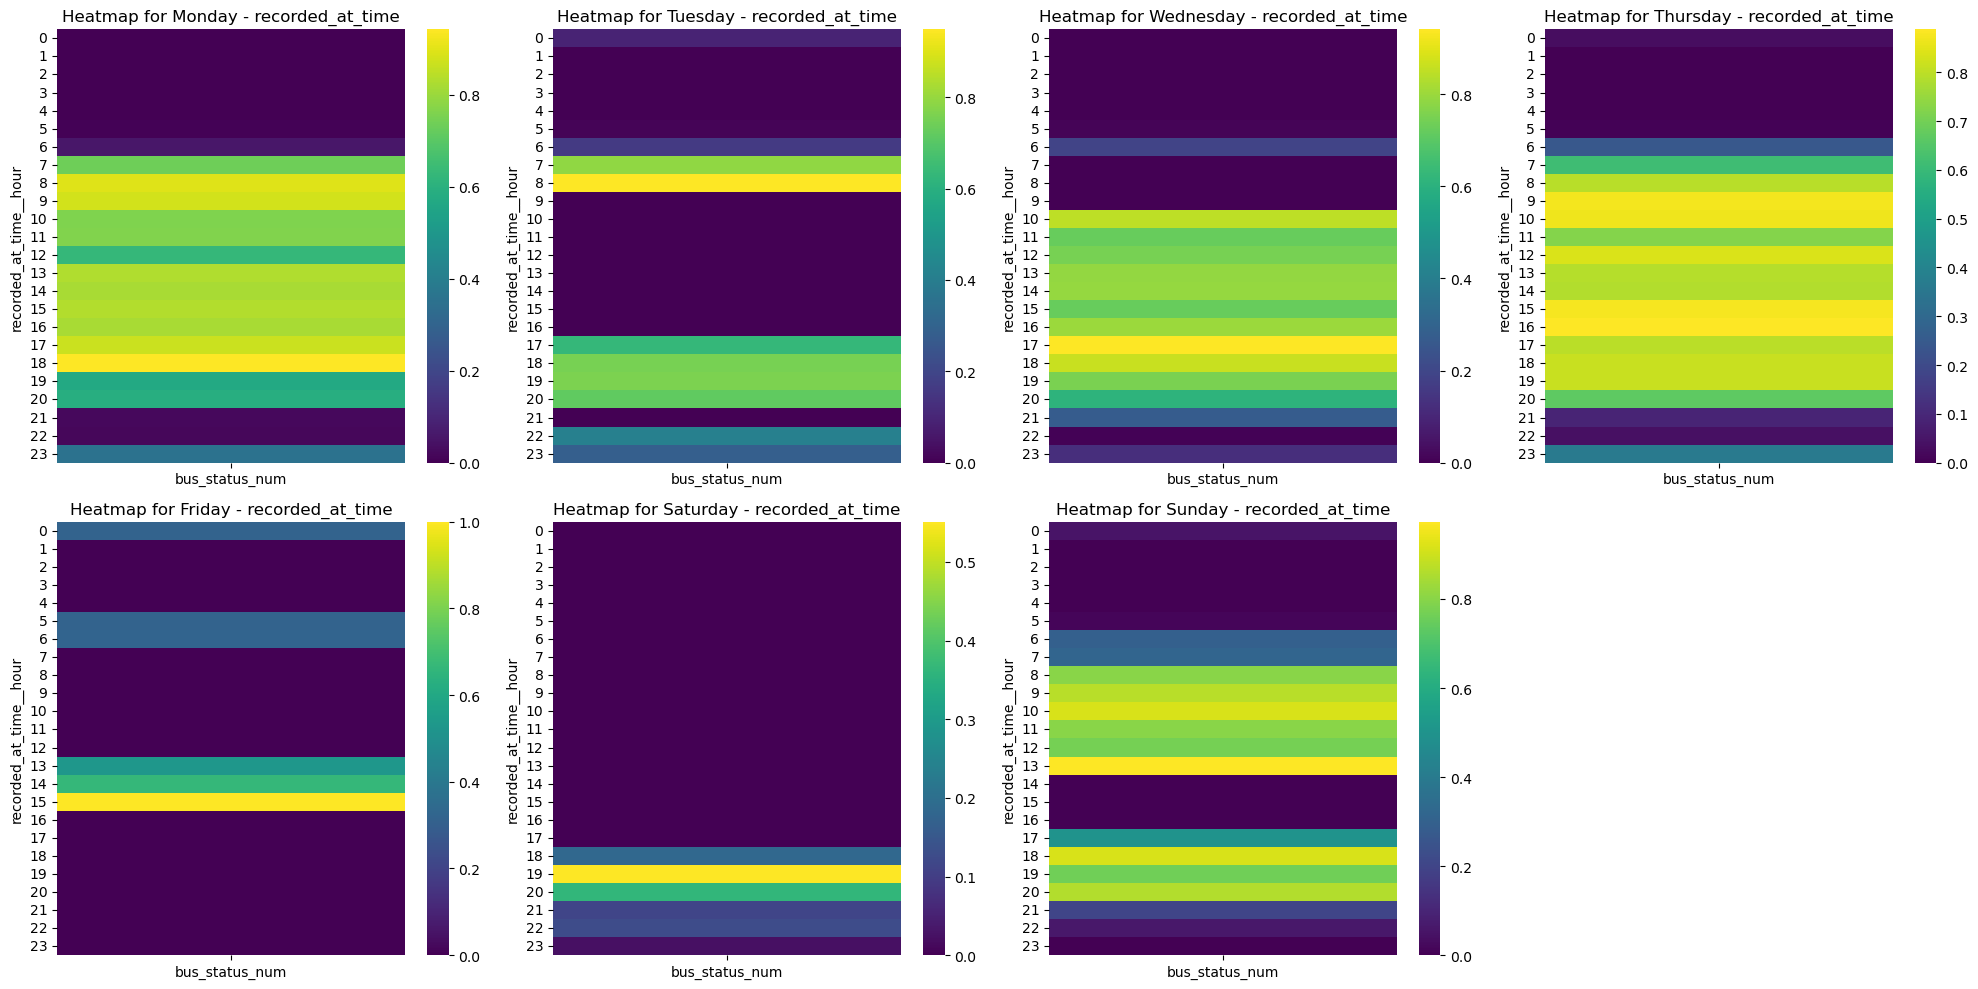

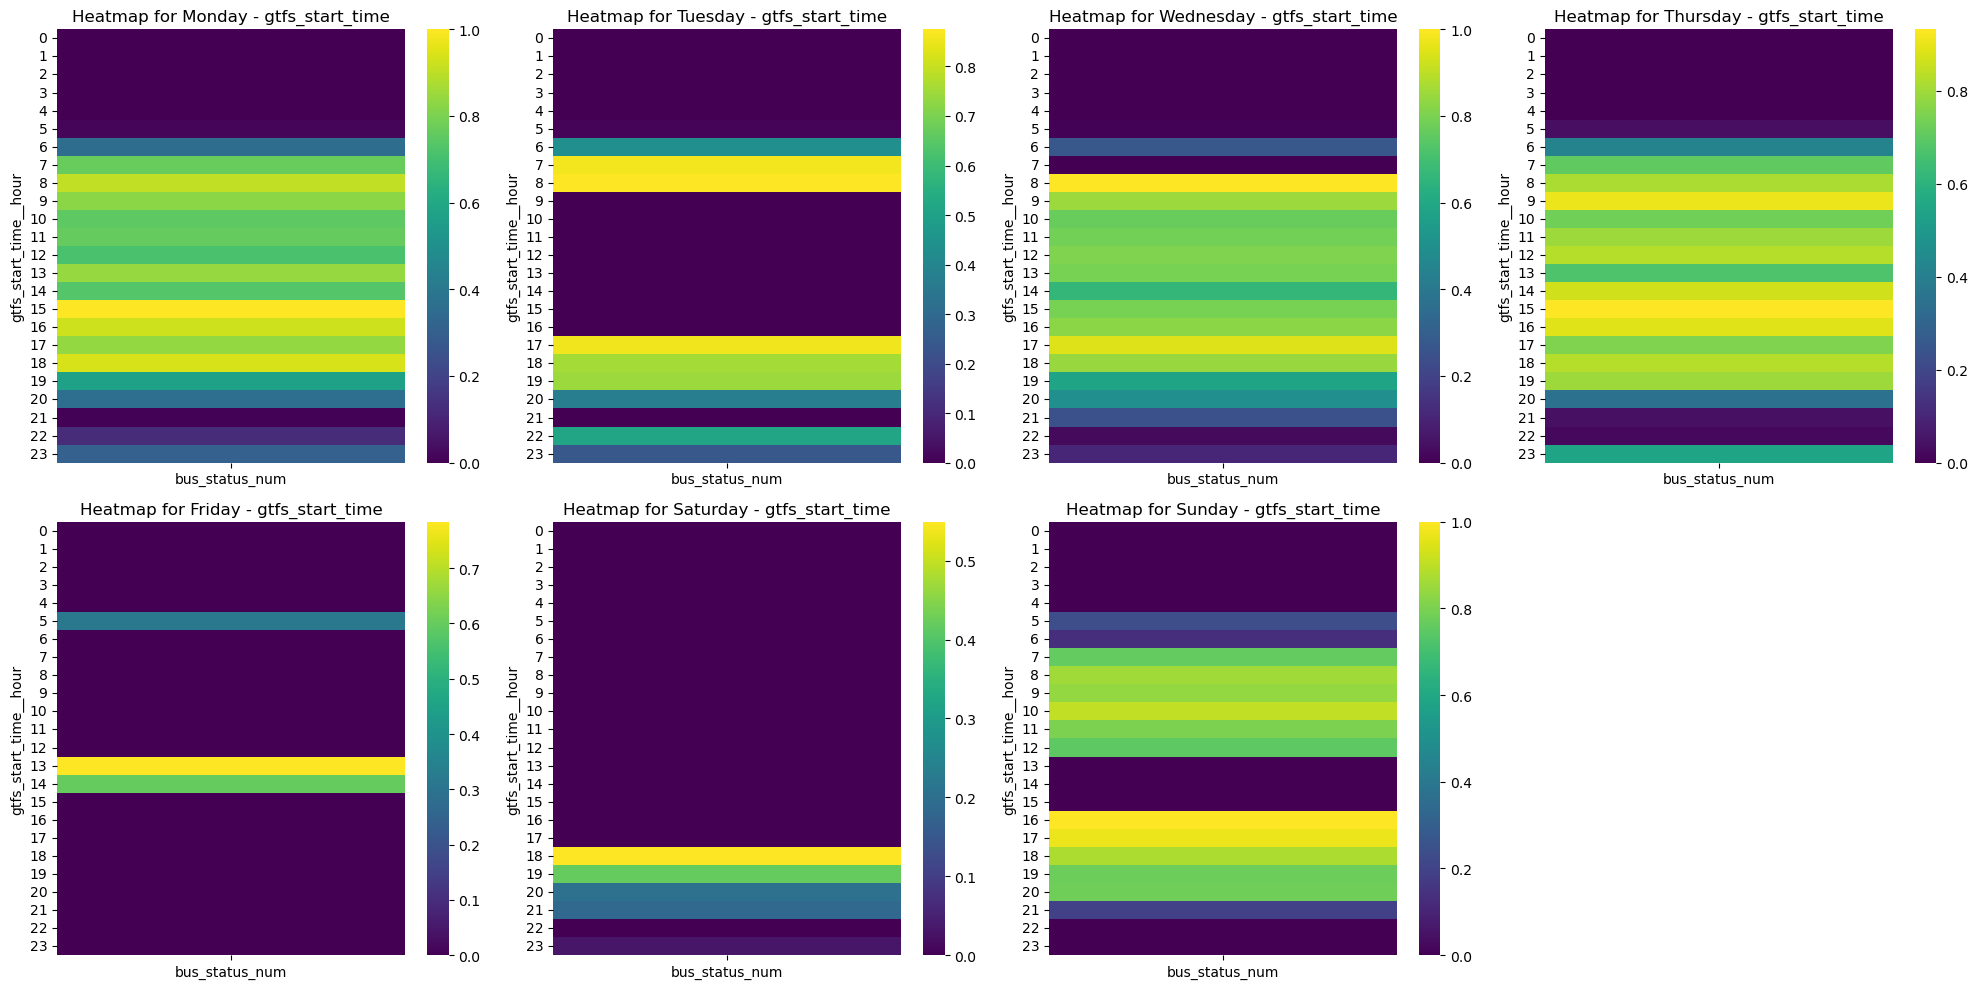

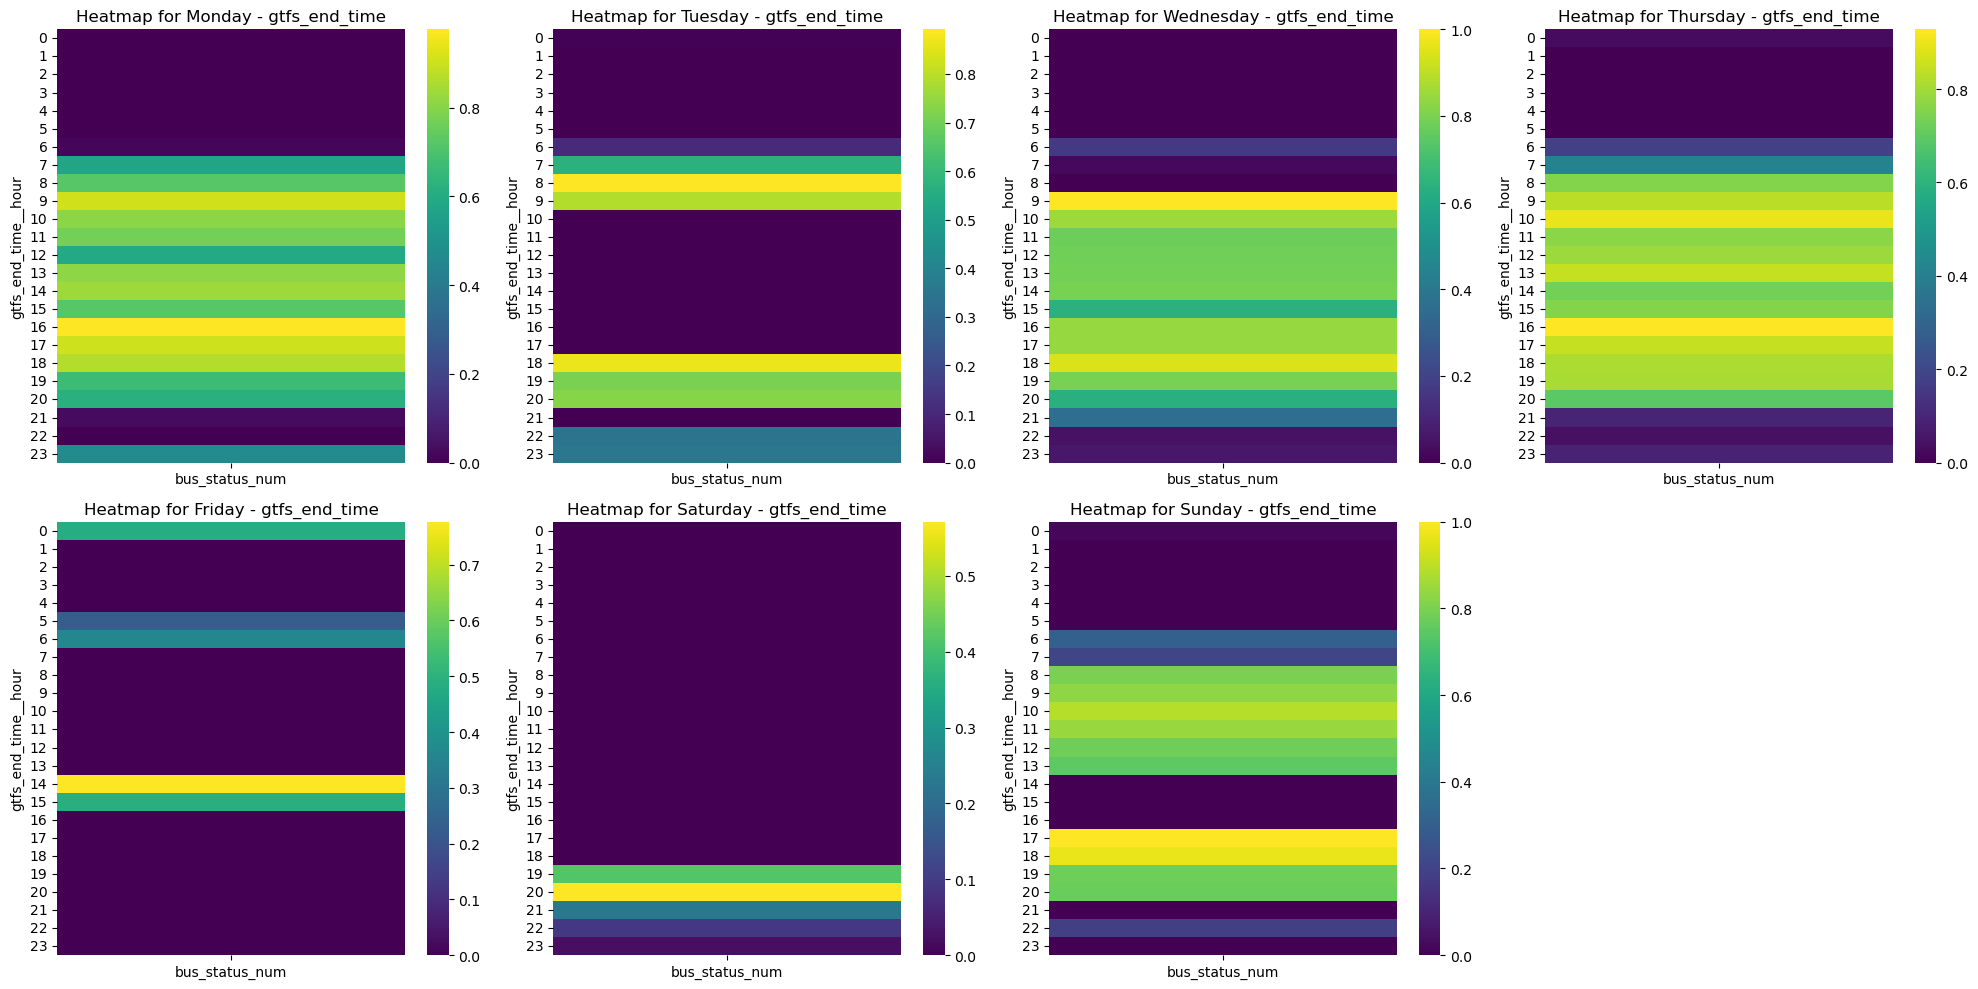

In [66]:
plot_heatmaps([recorded_time_pivot, start_time_pivot, end_time_pivot], ['recorded_at_time', 'gtfs_start_time', 'gtfs_end_time'])

## Bus Delays by City

In this analysis, we are investigating the delay of buses across different cities.

The Python code provided creates a pivot table from the `results` DataFrame, using the 'gtfs_stop_city' column as the index and the 'bus_status_num' column as the values. The aggregation function used is 'mean', which gives us the average delay for each city.

A function `reverse_string(s)` is defined and applied to the index of the pivot table to reverse the order of the text.

A heatmap is then created using seaborn's `sns.heatmap()` function, visualizing the average delay of buses in different cities. The color intensity in the heatmap represents the magnitude of the delay.

By examining this heatmap, we can identify which cities experience the most significant bus delays.


In [ ]:
def plot_city_heatmap(results):
    pivot_table_city = results.pivot_table(index='gtfs_stop_city', values='bus_status_num', aggfunc='mean')

    def reverse_string(s):
        return s[::-1]

    pivot_table_city.index = pivot_table_city.index.map(reverse_string)

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table_city, annot=True, cmap='coolwarm')
    plt.show()

In [ ]:
plot_city_heatmap(results)

# Applying Analysis to the Entire Dataset

In this section, we will apply the analysis we have developed to the entire dataset. Given the large size of the data (approximately 800GB), we will process the data in batches. This approach allows us to efficiently handle the data without overloading the memory.

The steps we will follow are:

1. **Batch Creation**: We will create data batches, ensuring that each batch does not exceed a specified size limit. To maintain data integrity, we will ensure that all related lines (i.e., lines with the same 'siri_journey_ref') are included in the same batch.

2. **Batch Analysis**: We will apply our analysis to each batch individually. This includes any data cleaning, transformation, and statistical analysis we have previously defined.

3. **Results Aggregation**: After analyzing each batch, we will aggregate the results. This could involve combining the results into a single data structure, or it could involve saving the results of each batch's analysis to disk.

By processing the data in batches, we can scale our analysis to handle large datasets that would not otherwise fit into memory. Let's get started!


## Batch Creation Function

In this cell, we define a function `create_batch_df` to create data batches from the large dataset. The function takes the following parameters:

- `csv_dir`: The directory where the CSV files are stored.
- `batch_size_gb`: The maximum size of each batch in gigabytes.
- `last_journey_refs`: A set of 'siri_journey_ref' values that were included in the last batch and should be excluded from the current batch.
- `start_file`: The file to start reading from. If not specified, reading starts from the first file in the directory.
- `start_pos`: The position in the start file to start reading from.

The function works as follows:

1. It initializes an empty DataFrame for the batch and a set to keep track of the 'siri_journey_ref' values in the current batch.

2. It iterates over each file in the directory, starting from the `start_file` if specified.

3. For each file, it creates an iterator for the chunks in the file and reads the first chunk.

4. If there are any `last_journey_refs`, it excludes them from the chunk.

5. It then enters a loop where it adds the chunk to the batch if it doesn't exceed the `batch_size_gb`. If the batch size is exceeded, it adds only the rows with the same 'siri_journey_ref' as in the current batch.

6. The function returns the batch DataFrame, the set of 'siri_journey_ref' values in the current batch, the next chunk, the iterator for the next chunks, the next file, and the index of the next file.

By using this function, we can create manageable batches from the large dataset while ensuring that all related lines are included in the same batch.


In [ ]:
def create_batch_df(csv_dir, batch_size_gb, last_journey_refs=None, start_file=None, start_pos=0):
    # Convert batch size from GB to bytes
    batch_size_bytes = batch_size_gb * 1024 * 1024 * 1024

    # Get a list of all output CSV files
    csv_files = glob.glob(f'{csv_dir}/output_*.csv')
    csv_files.sort()

    # If a start file is specified, start from this file
    if start_file is not None:
        csv_files = csv_files[csv_files.index(start_file):]

    # Initialize an empty DataFrame for the batch
    batch_df = pd.DataFrame()

    # Initialize a set to keep track of the 'siri_journey_ref' values in the current batch
    current_journey_refs = set()

    for file in csv_files:
        # Create an iterator for the chunks in the CSV file
        chunk_iter = pd.read_csv(file, skiprows=range(1, start_pos+1), chunksize=10000)  # Adjust chunksize as needed

        # Read the first chunk
        chunk = next(chunk_iter)

        # If there are any last journey refs, exclude them from the chunk
        if last_journey_refs is not None:
            chunk = chunk[~chunk['siri_journey_ref'].isin(last_journey_refs)]

        while True:
            # Add the chunk to the batch if it doesn't exceed the batch size
            if (batch_df.memory_usage(index=True, deep=True).sum() + chunk.memory_usage(index=True, deep=True).sum()) <= batch_size_bytes:
                batch_df = pd.concat([batch_df, chunk])
                current_journey_refs.update(chunk['siri_journey_ref'].unique())
            else:
                # If the batch size is exceeded, add only the rows with the same 'siri_journey_ref' as in the current batch
                current_journey_refs_in_chunk = chunk['siri_journey_ref'].isin(current_journey_refs)
                if current_journey_refs_in_chunk.any():
                    batch_df = pd.concat([batch_df, chunk[current_journey_refs_in_chunk]])
                    chunk = chunk[~current_journey_refs_in_chunk]

                # Return the current DataFrame and the set of 'siri_journey_ref' values
                return batch_df, current_journey_refs, chunk, chunk_iter, file, csv_files.index(file)

            # Try to read the next chunk
            try:
                chunk = next(chunk_iter)
            except StopIteration:
                break

    # If all files have been processed, return the current DataFrame and the set of 'siri_journey_ref' values
    return batch_df, current_journey_refs, None, None, None, None

In [ ]:
# Specify the directory where your CSV files are located
csv_dir = f'{DATA_FOLDER}/concatenated_data'

# Create a batch of 50MB
batch_df, current_journey_refs, chunk, chunk_iter, file, file_index = create_batch_df(csv_dir, batch_size_gb=0.05)

In [ ]:
df_bus_journey_stops, df_locations = process_dataframe(batch_df)

df_locations = process_locations(df_locations)

results = calculate_arrival_times(df_locations, df_bus_journey_stops, bearing_threshold=30)

plot_journey('2023-01-04-231603', results)
